# MSDs JAX-MD vs LAMMPS

In [4]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

os.environ['JAX_PLATFORM_NAME'] = "cpu"
os.environ['JAX_PLATFORMS'] = "cpu"

In [5]:
import jax.numpy as jnp
import jax

import numpy as onp

import matplotlib.pyplot as plt
import random

from helpers import bridge, lammps

from MDAnalysis.analysis import rdf, msd
import MDAnalysis as mda

import pandas as pd

/home/florian/anaconda3/envs/jaxidp/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [21]:
import matplotlib
from matplotlib.ticker import FormatStrFormatter

plt.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 200
plt.rc('text.latex', preamble="\\usepackage{siunitx}")

### Load JAX-MD data

This assumes that the notebook [run_simulation.ipynb](./run_simulation.ipynb) has already been executed.

In [6]:
jaxmd_bridge = bridge.MDABridge.from_file("../data/demo_simulation/dump.npz")
unwrapped_trajectory = onp.load("../data/demo_simulation/unwrapped_trajectory.npz", allow_pickle=True)
jaxmd_bridge = bridge.MDABridge(unwrapped_trajectory["trajectory"], unwrapped_trajectory["dt_per_frame"], jaxmd_bridge.box_size, None)

jaxmd_universe = jaxmd_bridge.universe

jaxmd_times = [ts.time for ts in jaxmd_universe.trajectory]

print(jaxmd_times)

print(f"JAX-MD: Universe with {len(jaxmd_universe.atoms)} atoms and {jaxmd_universe.trajectory.n_frames} snapshots over {jaxmd_times[-1]}ps.")

[0.0, 0.288, 0.576, 0.8639999999999999, 1.152, 1.44, 1.7279999999999998, 2.016, 2.304, 2.5919999999999996, 2.88, 3.1679999999999997, 3.4559999999999995, 3.7439999999999998, 4.032, 4.319999999999999, 4.608, 4.896, 5.183999999999999, 5.4719999999999995, 5.76, 6.047999999999999, 6.335999999999999, 6.624, 6.911999999999999, 7.199999999999999, 7.4879999999999995, 7.776, 8.064, 8.351999999999999, 8.639999999999999, 8.927999999999999, 9.216, 9.504, 9.792, 10.08, 10.367999999999999, 10.655999999999999, 10.943999999999999, 11.232, 11.52, 11.808, 12.095999999999998, 12.383999999999999, 12.671999999999999, 12.959999999999999, 13.248, 13.536, 13.823999999999998, 14.111999999999998, 14.399999999999999, 14.687999999999999, 14.975999999999999, 15.264, 15.552, 15.839999999999998, 16.128, 16.416, 16.703999999999997, 16.991999999999997, 17.279999999999998, 17.567999999999998, 17.855999999999998, 18.144, 18.432, 18.72, 19.008, 19.296, 19.584, 19.872, 20.16, 20.447999999999997, 20.735999999999997, 21.0239

In [7]:
jaxmd_msd = msd.EinsteinMSD(jaxmd_universe.universe, "all")
jaxmd_msd.run()

result = jaxmd_msd.results.timeseries
jm_x, jm_y = onp.array(jaxmd_times), onp.array(result)

100%|██████████| 1029/1029 [00:00<00:00, 6933.80it/s]


# Load reference data

In [8]:
df = pd.read_csv("../data/veronika_daten/tip3p_piko_rigid_msd_output.dat", sep=" ")
rf_x, rf_y = onp.array(df["t"]), onp.array(df["msd"])

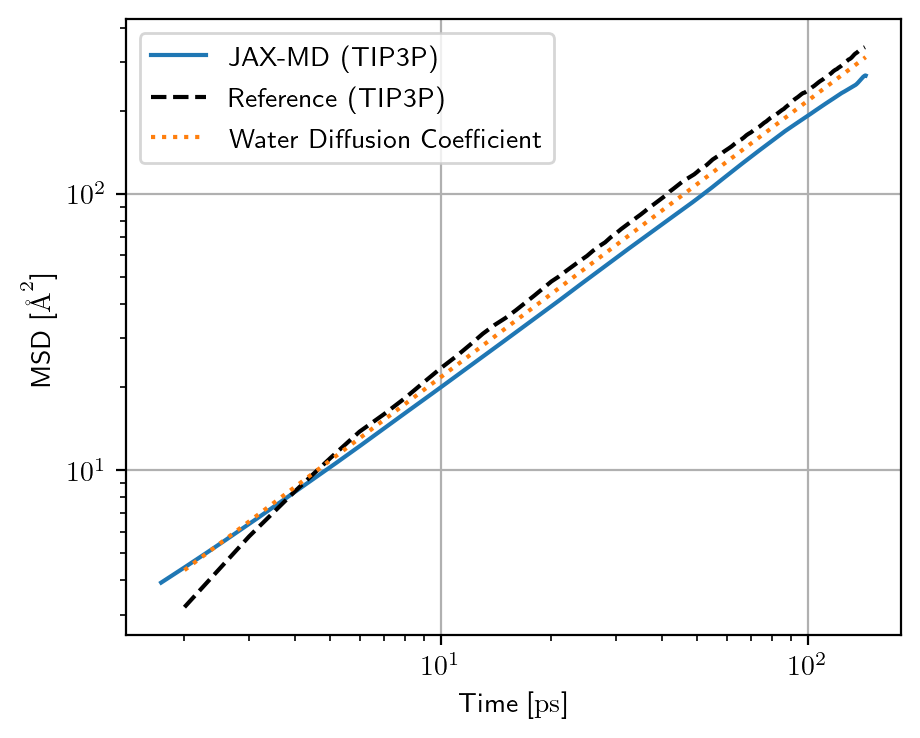

In [23]:
water_diff_coeff = 2.1745 # A^2/ps
plt.gcf().set_size_inches(5, 4)


max_jm_x = max(jm_x)
max_rf_ix = onp.argmin(onp.abs(rf_x - max_jm_x))

min_rf_x = min(rf_x)
min_jm_ix = 6 #onp.argmin(onp.abs(jm_x - min_rf_x))

plt.plot(jm_x[min_jm_ix:], jm_y[min_jm_ix:], label="JAX-MD (TIP3P)")
plt.plot(rf_x[1:max_rf_ix], rf_y[1:max_rf_ix], label="Reference (TIP3P)", c="black", linestyle="dashed")

x = onp.linspace(2, max(jm_x))
y = water_diff_coeff * x 
plt.plot(x,y, linestyle="dotted", label="Water Diffusion Coefficient")

plt.grid()
plt.xlabel("Time [$\\unit{\\pico\\second}$]")
plt.ylabel("MSD [$\\unit{\\angstrom^2}$]")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig("../plots/msd.svg")
plt.show()